In [102]:
import os

import lightgbm
import matplotlib.pyplot as plt
import pandas as pd
import shap
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split

C:\Users\karinoizerr\PycharmProjects\BestHack2022-DataScience\venv\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
C:\Users\karinoizerr\PycharmProjects\BestHack2022-DataScience\venv\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-whe

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


In [ ]:
DATA_PATH = os.path.join('data', 'transactions.csv')
TARGET_PATH = os.path.join('data', 'beeline_antispam_hakaton_id_samples.csv')

In [3]:
data = pd.read_csv(
    DATA_PATH,
    dtype={
        'time_zone': 'int8',
        'forward': 'int8',
        'zero_call_flg': 'int8',
        'source_b': 'int8',
        'source_f': 'int8',
        'num_b_length': 'int8',
        'duration': 'int16',
    },
    parse_dates=['datetime'],
)

## EDA

In [11]:
data = pd.read_csv(os.path.join('data', 'transactions.csv'), dtype=dtypes, parse_dates=['datetime'])
data = data.merge(targets, left_on='id_a', right_on='id', how='left')
data.head()

,id_a,id_b,time_zone,duration,forward,zero_call_flg,source_b,source_f,num_b_length,datetime,id,target,split
0,67596082,43588153,3,0,0,3,0,1,10,2021-11-01 18:43:03,67596082,чёрные спаммеры и мошенники,train
1,4024969,67656553,4,206,0,5,1,0,10,2021-11-01 11:43:20,4024969,NaN,test
2,43166780,31861625,0,5,0,0,0,1,10,2021-11-01 10:32:36,43166780,чёрные спаммеры и мошенники,train
3,51817902,41201237,3,0,0,0,0,1,10,2021-11-01 13:45:02,51817902,чёрные спаммеры и мошенники,train
4,41812796,4932754,0,0,0,5,0,1,10,2021-11-01 13:53:12,41812796,чёрные спаммеры и мошенники,train


In [12]:
def gen_quasi_target(row):
    result = None
    if row['split'] == 'train':
        result = row['target']
    elif row['split'] =='test':
        result = 'test'
    else:
        result = 'неразмеченные'

    return result


data['quasi_target_a'] = data.apply(gen_quasi_target, axis=1)

data.head()

,id_a,id_b,time_zone,duration,forward,zero_call_flg,source_b,source_f,num_b_length,datetime,id,target,split,quasi_target_a
0,67596082,43588153,3,0,0,3,0,1,10,2021-11-01 18:43:03,67596082,чёрные спаммеры и мошенники,train,чёрные спаммеры и мошенники
1,4024969,67656553,4,206,0,5,1,0,10,2021-11-01 11:43:20,4024969,NaN,test,test
2,43166780,31861625,0,5,0,0,0,1,10,2021-11-01 10:32:36,43166780,чёрные спаммеры и мошенники,train,чёрные спаммеры и мошенники
3,51817902,41201237,3,0,0,0,0,1,10,2021-11-01 13:45:02,51817902,чёрные спаммеры и мошенники,train,чёрные спаммеры и мошенники
4,41812796,4932754,0,0,0,5,0,1,10,2021-11-01 13:53:12,41812796,чёрные спаммеры и мошенники,train,чёрные спаммеры и мошенники


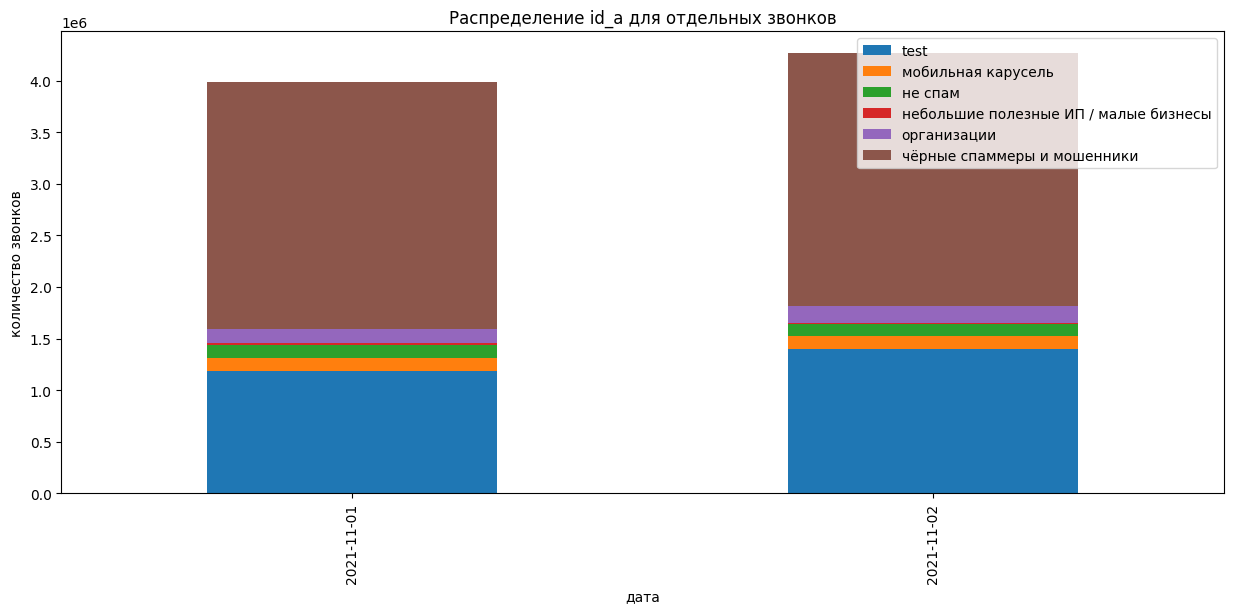

In [13]:
grouped = data.groupby([pd.Grouper(key='datetime', freq='D'), 'quasi_target_a'])['time_zone'].count().unstack()

fig, ax = plt.subplots(figsize=(15, 6))

grouped.plot(kind='bar', stacked=True, rot=90, title='Распределение id_a для отдельных звонков', ax=ax)
ax.set(xlabel='дата', xticklabels=grouped.index.format(), ylabel='количество звонков')
ax.legend(title=None)

plt.show()

In [14]:
for i in ['id', 'target', 'split']:
    del data[i]

In [15]:
data = data.merge(targets, left_on='id_b', right_on='id', how='left')
data.head()

,id_a,id_b,time_zone,duration,forward,zero_call_flg,source_b,source_f,num_b_length,datetime,quasi_target_a,id,target,split
0,67596082,43588153,3,0,0,3,0,1,10,2021-11-01 18:43:03,чёрные спаммеры и мошенники,NaN,NaN,NaN
1,4024969,67656553,4,206,0,5,1,0,10,2021-11-01 11:43:20,test,NaN,NaN,NaN
2,43166780,31861625,0,5,0,0,0,1,10,2021-11-01 10:32:36,чёрные спаммеры и мошенники,NaN,NaN,NaN
3,51817902,41201237,3,0,0,0,0,1,10,2021-11-01 13:45:02,чёрные спаммеры и мошенники,NaN,NaN,NaN
4,41812796,4932754,0,0,0,5,0,1,10,2021-11-01 13:53:12,чёрные спаммеры и мошенники,NaN,NaN,NaN


In [16]:
data['quasi_target_b'] = data.apply(gen_quasi_target, axis=1)

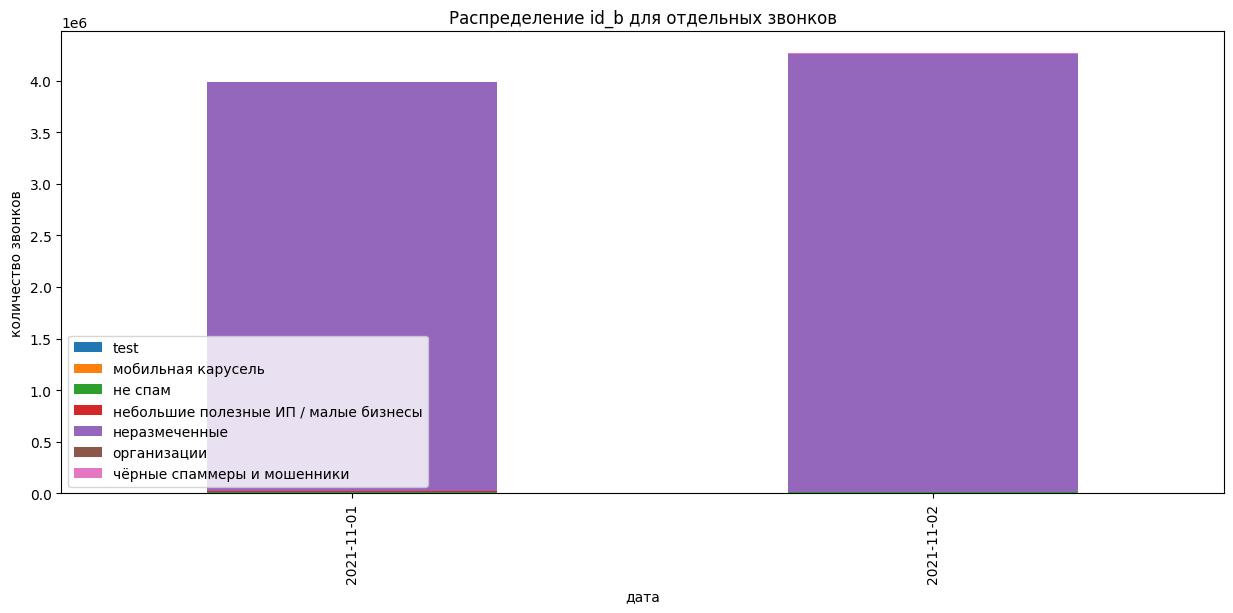

In [17]:
grouped = data.groupby([pd.Grouper(key='datetime', freq='D'), 'quasi_target_b'])['time_zone'].count().unstack()

fig, ax = plt.subplots(figsize=(15, 6))

grouped.plot(kind='bar', stacked=True, rot=90, title='Распределение id_b для отдельных звонков', ax=ax)
ax.set(xlabel='дата', xticklabels=grouped.index.format(), ylabel='количество звонков')
ax.legend(title=None)

plt.show()

In [18]:
for i in ['id', 'target', 'split']:
    del data[i]

## Агрегации

In [123]:
aggregated = data.groupby('id_a').aggregate(
    # всего звонков
    calls_count=pd.NamedAgg(column='duration', aggfunc='count'),
    # средняя продолжительность звонка
    duration_mean=pd.NamedAgg(column='duration', aggfunc='mean'),
    # стандартное отклонение продолжительности звонка
    duration_std=pd.NamedAgg(column='duration', aggfunc='std'),
    # количество уникальных адресатов
    nunique_dst=pd.NamedAgg(column='id_b', aggfunc='nunique'),
    # средний перерыв между звонками в секундах
    mean_diff=pd.NamedAgg(column='datetime', aggfunc=lambda s: s.diff()[1:].dt.seconds.mean()),
    # стандартное отклонение перерывов между звонками в секундах
    std_diff=pd.NamedAgg(column='datetime', aggfunc=lambda s: s.diff()[1:].dt.seconds.std()),
    # 
    nunique_time_zone=pd.NamedAgg(column='time_zone', aggfunc='nunique'),
    #
    nunique_source_b=pd.NamedAgg(column='source_b', aggfunc='nunique'),
    #
    nunique_source_f=pd.NamedAgg(column='source_f', aggfunc='nunique'),
)
aggregated = aggregated.reset_index()
aggregated.head()

,id_a,calls_count,duration_mean,duration_std,nunique_dst,mean_diff,std_diff,nunique_time_zone,nunique_source_b,nunique_source_f
0,1872,2,26.000000,25.455844,1,85510.000000,NaN,1,1,1
1,3858,3,15.333333,26.558112,2,12273.000000,17343.915129,1,1,1
2,4357,2,23.500000,33.234019,2,16527.000000,NaN,2,1,1
3,14838,8,16.125000,14.701190,3,41578.714286,34164.441298,2,2,1
4,17884,7,64.285714,66.667619,3,68121.000000,33758.444520,1,1,1


In [124]:
aggregated = aggregated.merge(targets, left_on='id_a', right_on='id', how='left')
aggregated = aggregated.drop(columns=['id_a', 'id'])
aggregated.head()

,calls_count,duration_mean,duration_std,nunique_dst,mean_diff,std_diff,nunique_time_zone,nunique_source_b,nunique_source_f,target,split
0,2,26.000000,25.455844,1,85510.000000,NaN,1,1,1,не спам,train
1,3,15.333333,26.558112,2,12273.000000,17343.915129,1,1,1,чёрные спаммеры и мошенники,train
2,2,23.500000,33.234019,2,16527.000000,NaN,2,1,1,организации,train
3,8,16.125000,14.701190,3,41578.714286,34164.441298,2,2,1,не спам,train
4,7,64.285714,66.667619,3,68121.000000,33758.444520,1,1,1,не спам,train


In [125]:
train = aggregated.query('split == "train"')
test = aggregated.query('split == "test"')

In [126]:
X = train.drop(columns=['target', 'split'])
y = train['target']

In [127]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    random_state=42,
)

In [128]:
model = lightgbm.LGBMClassifier(
    objective='multiclass',
    is_unbalance=True,
    random_state=42,
)
model.fit(X_train, y_train)

LGBMClassifier(is_unbalance=True, objective='multiclass', random_state=42)

In [129]:
y_pred = model.predict(X_test)

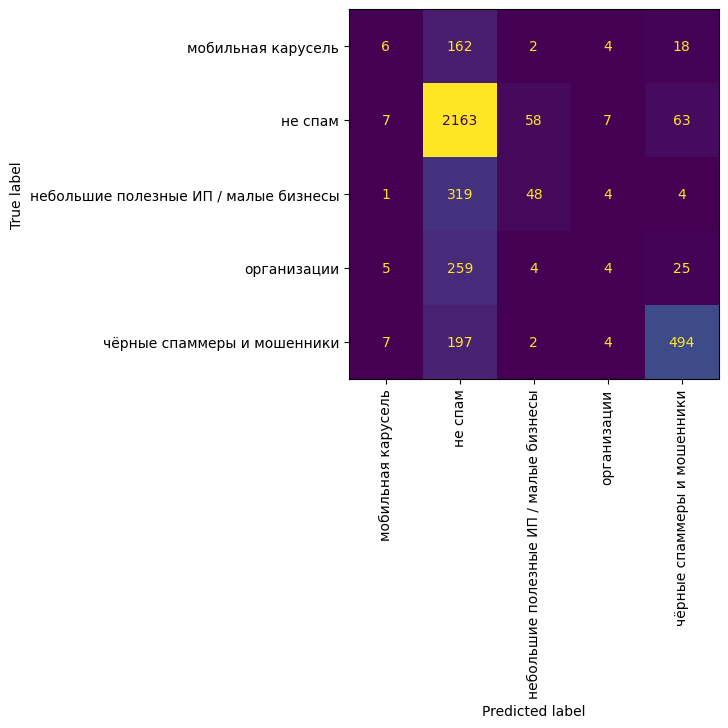

In [130]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, colorbar=False, xticks_rotation='vertical', ax=ax)
plt.show()

In [131]:
fbeta_score(y_test, y_pred, average='macro', beta=0.5)

0.3937415669488322

In [132]:
# explainer = shap.TreeExplainer(model)